In [11]:
# Module Import
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
import json
from IPython.display import display
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization,
    GRU, LSTM, Bidirectional,
    Conv1D, MaxPooling1D, GlobalAveragePooling1D,
    LayerNormalization, MultiHeadAttention, Add
)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tcn import TCN

In [12]:
# 데이터 전처리
data = pd.read_csv("../frontend/public/sensor.csv")

all_zero_cols = data.columns[(data == 0).all()].tolist()
all_nan_cols = data.columns[data.isna().all()].tolist()
threshold = 1.2
low_std_cols = data.std(numeric_only=True).loc[lambda x: x < threshold].index.tolist()
useless_columns = list(set(all_zero_cols + all_nan_cols + low_std_cols))
data = data.drop(columns=useless_columns)

status_map = {'NORMAL': 0, 'RECOVERING': 1, 'BROKEN': 2}
data['machine_status_encoded'] = data['machine_status'].map(status_map)

data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)
data = data.interpolate(method='time')

sensor_cols = [col for col in data.columns if col.startswith('sensor')]
scaler = StandardScaler()
data[sensor_cols] = scaler.fit_transform(data[sensor_cols])

data = data.drop(columns=['machine_status'])
data = data.sort_index()
data.columns

C:\Users\LEETJ\AppData\Local\Temp\ipykernel_2980\1390813879.py:16: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='time')


Index(['Unnamed: 0', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_19', 'sensor_20', 'sensor_21',
       'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26',
       'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30', 'sensor_31',
       'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35', 'sensor_36',
       'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40', 'sensor_41',
       'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45', 'sensor_46',
       'sensor_47', 'sensor_48', 'sensor_49', 'sensor_50', 'sensor_51',
       'machine_status_encoded'],
      dtype='object')

In [13]:
# 데이터 분할 학습(60%), 테스트(40%)
total_rows = len(data)
split_idx = int(total_rows * 0.6)
train_data = data.iloc[:split_idx]
test_data = data.iloc[split_idx:]

print(total_rows)
print(len(train_data))
print(len(test_data))

220320
132192
88128


In [14]:
# 트렌드 예측 window 생성
def create_sensor_trend_windows(data, sensor_cols, window_size=60, step=1):
    sensor_data = data[sensor_cols].to_numpy(dtype=np.float32)
    num_windows = (len(sensor_data) - window_size) // step

    X = np.empty((num_windows, window_size, len(sensor_cols)), dtype=np.float32)
    y = np.empty((num_windows, len(sensor_cols)), dtype=np.float32)

    for i in range(num_windows):
        idx = i * step
        X[i] = sensor_data[idx:idx + window_size]
        y[i] = sensor_data[idx + window_size]
    return X, y

X_train, y_train = create_sensor_trend_windows(train_data, sensor_cols)
X_test, y_test = create_sensor_trend_windows(test_data, sensor_cols)

In [15]:
# 데이터 축소 (10% 샘플링)
subset_size = int(len(X_train) * 0.1)
X_train_small = X_train[:subset_size]
y_train_small = y_train[:subset_size]

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

def evaluate_model(name, y_true, y_pred):
    mse_list = [mean_squared_error(y_true[:, i], y_pred[:, i]) for i in range(len(sensor_cols))]
    return pd.DataFrame({'Sensor': sensor_cols, f'{name}_MSE': mse_list})

print(len(X_train_small))
print(len(y_train_small))

13213
13213


In [23]:
# 10% 데이터로 약식 평가
# GRU
gru_model = Sequential([
    GRU(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(len(sensor_cols))
])
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train_small, y_train_small, validation_split=0.2, epochs=5, batch_size=64, verbose=0)
gru_y_pred = gru_model.predict(X_test)
df_gru = evaluate_model('GRU', y_test, gru_y_pred)

# LSTM
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(len(sensor_cols))
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_small, y_train_small, validation_split=0.2, epochs=5, batch_size=64, verbose=0)
lstm_y_pred = lstm_model.predict(X_test)
df_lstm = evaluate_model('LSTM', y_test, lstm_y_pred)

# BiLSTM
bilstm_model = Sequential([
    Bidirectional(LSTM(64), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(len(sensor_cols))
])
bilstm_model.compile(optimizer='adam', loss='mse')
bilstm_model.fit(X_train_small, y_train_small, validation_split=0.2, epochs=5, batch_size=64, verbose=0)
bilstm_y_pred = bilstm_model.predict(X_test)
df_bilstm = evaluate_model('BiLSTM', y_test, bilstm_y_pred)

# TCN
tcn_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    TCN(nb_filters=32, kernel_size=3, dilations=[1, 2, 4], dropout_rate=0.1),
    Dense(len(sensor_cols))
])
tcn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
tcn_model.fit(X_train_small, y_train_small, validation_split=0.2, epochs=5, batch_size=64, verbose=0, callbacks=[early_stop])
tcn_y_pred = tcn_model.predict(X_test)
df_tcn = evaluate_model('TCN', y_test, tcn_y_pred)

# 1D-CNN
cnn_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    GlobalAveragePooling1D(),
    Dense(len(sensor_cols))
])
cnn_model.compile(optimizer='adam', loss='mse')
cnn_model.fit(X_train_small, y_train_small, validation_split=0.2, epochs=5, batch_size=64, verbose=0)
cnn_y_pred = cnn_model.predict(X_test)
df_cnn = evaluate_model('1D_CNN', y_test, cnn_y_pred)

# Transformer
def transformer_block(inputs, num_heads=2, ff_dim=64, dropout=0.1):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attn_output = Dropout(dropout)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    ff_output = Dense(ff_dim, activation='relu')(out1)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout)(ff_output)
    return LayerNormalization(epsilon=1e-6)(out1 + ff_output)

input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = transformer_block(input_layer)
x = GlobalAveragePooling1D()(x)
output_layer = Dense(len(sensor_cols))(x)

transformer_model = Model(inputs=input_layer, outputs=output_layer)
transformer_model.compile(optimizer='adam', loss='mse')
transformer_model.fit(X_train_small, y_train_small, validation_split=0.2, epochs=5, batch_size=64, verbose=0)
transformer_y_pred = transformer_model.predict(X_test)
df_trans = evaluate_model('Transformer', y_test, transformer_y_pred)

c:\Users\LEETJ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2753/2753 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


c:\Users\LEETJ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2753/2753 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step


c:\Users\LEETJ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2753/2753 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step
2753/2753 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


c:\Users\LEETJ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2753/2753 ━━━━━━━━━━━━━━━━━━━━ 2s 595us/step
2753/2753 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


In [17]:
# 약식 평가 MSE 결과
model_dfs = [df_gru, df_lstm, df_bilstm, df_tcn, df_cnn, df_trans]
model_names = ['GRU', 'LSTM', 'BiLSTM', 'TCN', '1D_CNN', 'Transformer']

df_all = pd.DataFrame()
for df, name in zip(model_dfs, model_names):
    df_temp = df.copy()
    df_temp.columns = ['Sensor', 'MSE']
    df_temp['Model'] = name
    df_all = pd.concat([df_all, df_temp], axis=0)

print("모델별 센서 예측 MSE")
display(df_all.pivot(index='Sensor', columns='Model', values='MSE'))

# 모델별 평균 성능 출력
print("모델별 평균 MSE 요약")
avg_mse_summary = df_all.groupby('Model')['MSE'].mean().sort_values()
display(avg_mse_summary.round(5).to_frame(name='Average_MSE'))


모델별 센서 예측 MSE


Model        1D_CNN    BiLSTM       GRU      LSTM       TCN  Transformer
Sensor                                                                  
sensor_01  0.753845  0.612034  0.185581  0.675292  1.640047     1.054108
sensor_02  0.159536  0.673504  0.601015  1.038763  1.723421     0.987764
sensor_03  0.419954  0.303256  0.164171  0.616525  1.898933     0.521281
sensor_04  1.222586  0.743676  0.673145  0.841576  1.515932     0.803423
sensor_05  0.522705  0.519942  0.331862  0.482861  1.060243     1.281628
sensor_06  1.303280  0.761285  0.703853  1.012261  0.815129     1.254622
sensor_07  1.541803  1.034645  1.099230  0.937648  1.047188     1.079574
sensor_08  2.102078  0.985992  0.830039  1.234212  1.510943     1.017020
sensor_09  1.214779  0.929443  0.788058  1.167212  1.604174     1.543234
sensor_10  0.541540  0.443127  0.377672  0.515870  1.101101     2.216715
sensor_11  0.443446  0.594902  0.458951  0.589939  0.719387     0.671515
sensor_12  0.263729  0.432017  0.223534  0.619110  0.857652     1.162191
sensor_13  0.750309  0.420829  0.170221  0.255367  1.245957     1.324882
sensor_14  0.282964  0.316261  0.114279  0.075626  0.111400     0.133732
sensor_16  0.067354  0.203406  0.044673  0.056263  0.403565     0.160287
sensor_17  0.462061  0.539580  0.037540  0.037466  0.258682     0.413622
sensor_19  0.346758  0.177974  0.068878  0.056747  0.445799     0.176477
sensor_20  0.285460  0.209246  0.090484  0.185484  0.273978     0.274219
sensor_21  0.313264  0.074982  0.060461  0.089069  0.247431     0.122130
sensor_22  0.296499  0.141592  0.051489  0.188995  0.192897     0.145816
sensor_23  0.379623  0.426565  0.367658  0.307301  0.349644     0.888915
sensor_24  0.232694  0.151533  0.109678  0.237141  0.208328     0.168554
sensor_25  0.124934  0.337869  0.120603  0.130061  0.434700     0.365697
sensor_26  0.353507  0.438902  0.337545  0.353396  0.501331     0.325657
sensor_27  1.227985  0.333484  0.263399  0.491666  1.175770     1.362790
sensor_28  0.189671  0.212971  0.091418  0.156876  0.467874     0.215762
sensor_29  0.143551  0.094200  0.170800  0.228061  1.329103     0.859286
sensor_30  0.241740  0.392078  0.289615  0.122339  0.207893     0.233465
sensor_31  0.145831  0.245681  0.089156  0.094908  0.509567     0.203042
sensor_32  0.649689  0.230458  0.251103  0.214481  0.597245     0.278767
sensor_33  0.350922  0.108884  0.064512  0.098914  0.500672     0.652014
sensor_34  1.311586  1.050932  0.816302  0.831119  1.694647     0.673733
sensor_35  1.855143  0.587448  1.199842  1.232128  2.393624     1.580760
sensor_36  0.746666  0.416362  0.111440  0.133994  1.108411     0.443846
sensor_37  1.802421  0.393556  0.526144  0.505571  4.672779     4.030635
sensor_38  0.664420  0.585237  0.320943  0.375453  0.823413     1.510107
sensor_39  0.638437  0.516084  0.321542  0.507704  0.477161     0.799845
sensor_40  0.897604  0.327643  0.268805  0.263412  3.056159     1.372968
sensor_41  0.495709  0.501970  0.675336  0.485348  0.683310     0.755715
sensor_42  0.282520  0.365087  0.238379  0.293930  0.555240     0.416747
sensor_43  1.215071  0.575539  0.238707  0.465034  0.532091     1.213840
sensor_44  1.609845  0.725449  0.474686  0.722846  1.421394     1.456555
sensor_45  1.427465  0.639485  0.261402  0.568044  3.884526     1.895351
sensor_46  2.123000  0.375427  0.227047  0.284518  2.896614     3.833933
sensor_47  1.259415  0.773463  0.424738  0.590922  2.455409     1.778871
sensor_48  1.126443  0.224296  0.073271  0.155712  1.162655     0.648113
sensor_49  0.850410  0.550879  0.204324  0.362552  0.549916     1.317732
sensor_50  2.478101  1.958556  1.676141  2.001842  3.262923     2.472575
sensor_51  0.336875  0.208839  0.198459  0.218354  0.218891     0.432973

모델별 평균 MSE 요약


Average_MSE
Model                   
GRU              0.35690
LSTM             0.47163
BiLSTM           0.48707
1D_CNN           0.78480
Transformer      0.99046
TCN              1.15929

In [18]:
# 주요 모델 전체 데이터로 학습 (GRU, BiLSTM, LSTM)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# GRU
gru_trend_model = Sequential([
    GRU(128, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(len(sensor_cols))
])
gru_trend_model.compile(
    optimizer='adam',
    loss='mse'
)
gru_trend_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=128,
    callbacks=[early_stop],
    verbose=0
)

# BiLSTM
bilstm_trend_model = Sequential([
    Bidirectional(LSTM(128), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(len(sensor_cols))
])
bilstm_trend_model.compile(
    optimizer='adam',
    loss='mse'
)
bilstm_trend_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=128,
    callbacks=[early_stop],
    verbose=0
)

# LSTM
lstm_trend_model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(len(sensor_cols))
])
lstm_trend_model.compile(
    optimizer='adam',
    loss='mse'
)
lstm_trend_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=128,
    callbacks=[early_stop],
    verbose=0
)

c:\Users\LEETJ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\LEETJ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
# GRU, BiLSTM, LSTM 학습 평가
models_info = {
    "GRU": gru_trend_model,
    "LSTM": lstm_trend_model,
    "BiLSTM": bilstm_trend_model
}

all_metrics = {}

for model_name, model in models_info.items():
    X_init = train_data[sensor_cols].values[-60:].reshape(1, 60, len(sensor_cols))
    first_y_pred = model.predict(X_init, verbose=0)
    y_pred_rest = model.predict(X_test, verbose=0)
    y_pred_full = np.vstack([first_y_pred, y_pred_rest])

    metrics = []
    for i, sensor in enumerate(sensor_cols):
        pred = y_pred_full[:, i]
        actual = y_test[:, i]

        mse = mean_squared_error(actual, pred[1:])
        mae = mean_absolute_error(actual, pred[1:])
        r2 = r2_score(actual, pred[1:])

        metrics.append({
            "Sensor": sensor,
            "MSE": round(mse, 5),
            "MAE": round(mae, 5),
            "R2": round(r2, 5)
        })

    df = pd.DataFrame(metrics)
    df["Model"] = model_name
    all_metrics[model_name] = df

combined_df = pd.concat(all_metrics.values(), ignore_index=True)

print("센서별 모델 성능 (MSE/MAE/R²)")
display(combined_df.pivot(index='Sensor', columns='Model', values='MSE').round(5))

print("모델별 평균 성능 요약")
avg_summary_df = combined_df.groupby("Model")[["MSE", "MAE", "R2"]].mean().round(5)
display(avg_summary_df)


센서별 모델 성능 (MSE/MAE/R²)


Model       BiLSTM      GRU     LSTM
Sensor                              
sensor_01  0.24059  0.03184  0.11423
sensor_02  0.07437  0.02619  0.06564
sensor_03  0.36822  0.00985  0.06674
sensor_04  0.05779  0.04642  0.02589
sensor_05  0.10820  0.02678  0.05244
sensor_06  0.06541  0.02710  0.05766
sensor_07  0.02552  0.02244  0.03380
sensor_08  0.09865  0.03205  0.03454
sensor_09  0.05442  0.02126  0.02882
sensor_10  0.06513  0.02871  0.03761
sensor_11  0.08914  0.04119  0.09166
sensor_12  0.09221  0.02718  0.07092
sensor_13  0.12898  0.02618  0.19140
sensor_14  0.04830  0.01429  0.00858
sensor_16  0.02703  0.00949  0.00975
sensor_17  0.12121  0.01187  0.01100
sensor_19  0.03504  0.01100  0.00450
sensor_20  0.04070  0.00851  0.00750
sensor_21  0.05240  0.01552  0.00872
sensor_22  0.02663  0.00804  0.01053
sensor_23  0.04616  0.01011  0.01604
sensor_24  0.02208  0.01042  0.00968
sensor_25  0.02353  0.00968  0.01122
sensor_26  0.07235  0.01288  0.02503
sensor_27  0.27360  0.07401  0.24194
sensor_28  0.07818  0.01632  0.06122
sensor_29  0.11242  0.04682  0.04716
sensor_30  0.07665  0.02191  0.04935
sensor_31  0.22460  0.03947  0.05293
sensor_32  0.12794  0.03360  0.07158
sensor_33  0.06775  0.01238  0.02732
sensor_34  0.11751  0.03039  0.09005
sensor_35  0.11412  0.07760  0.11239
sensor_36  0.08666  0.01662  0.06263
sensor_37  0.27762  0.10832  0.39604
sensor_38  0.60696  0.09473  0.08901
sensor_39  0.33887  0.06549  0.08109
sensor_40  0.13279  0.18333  0.07522
sensor_41  0.31696  0.09524  0.07493
sensor_42  0.26176  0.05280  0.05557
sensor_43  0.18394  0.16829  0.05736
sensor_44  0.47054  0.30990  0.35418
sensor_45  0.16694  0.16801  0.09101
sensor_46  0.10450  0.18077  0.08447
sensor_47  0.20667  0.13640  0.12251
sensor_48  0.20130  0.20817  0.10362
sensor_49  0.16865  0.16422  0.15344
sensor_50  0.56459  0.01532  0.59638
sensor_51  0.21613  0.01854  0.04282

모델별 평균 성능 요약


MSE      MAE       R2
Model                            
BiLSTM  0.15269  0.26186  0.32722
GRU     0.05771  0.14800  0.80757
LSTM    0.08547  0.18262  0.72945

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2753/2753 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step


C:\Users\LEETJ\AppData\Local\Temp\ipykernel_2980\2018597821.py:56: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\LEETJ\AppData\Local\Temp\ipykernel_2980\2018597821.py:56: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\LEETJ\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\LEETJ\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


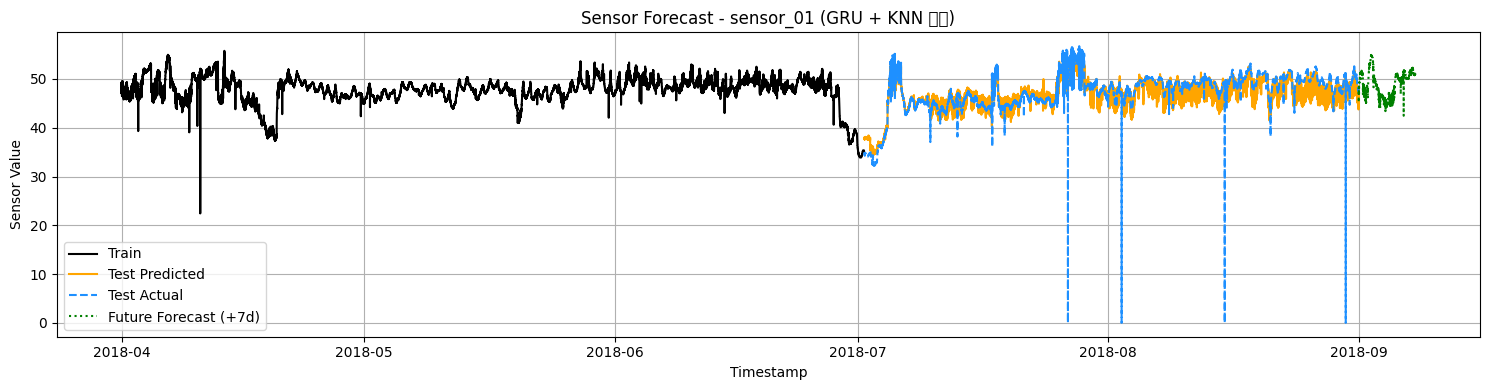

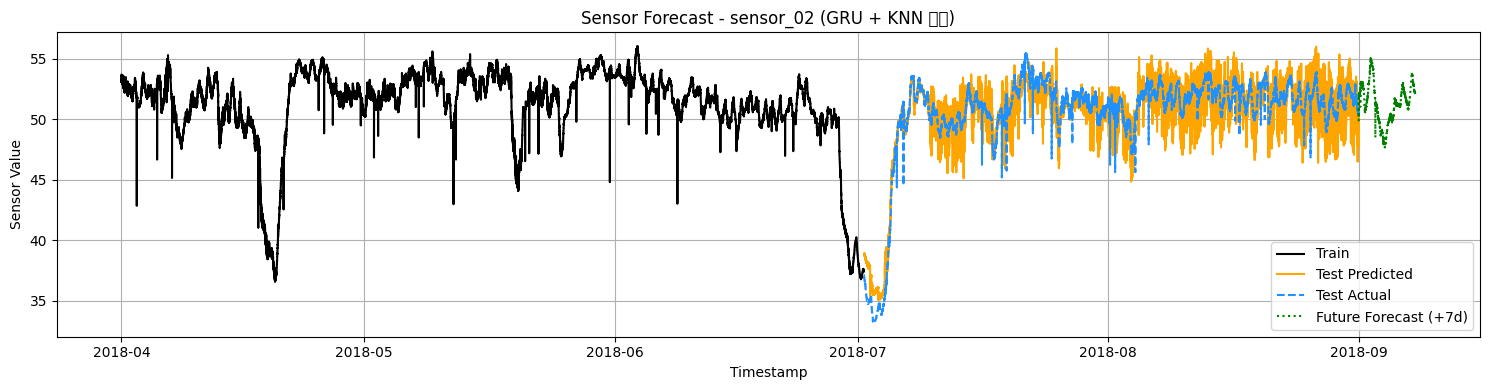

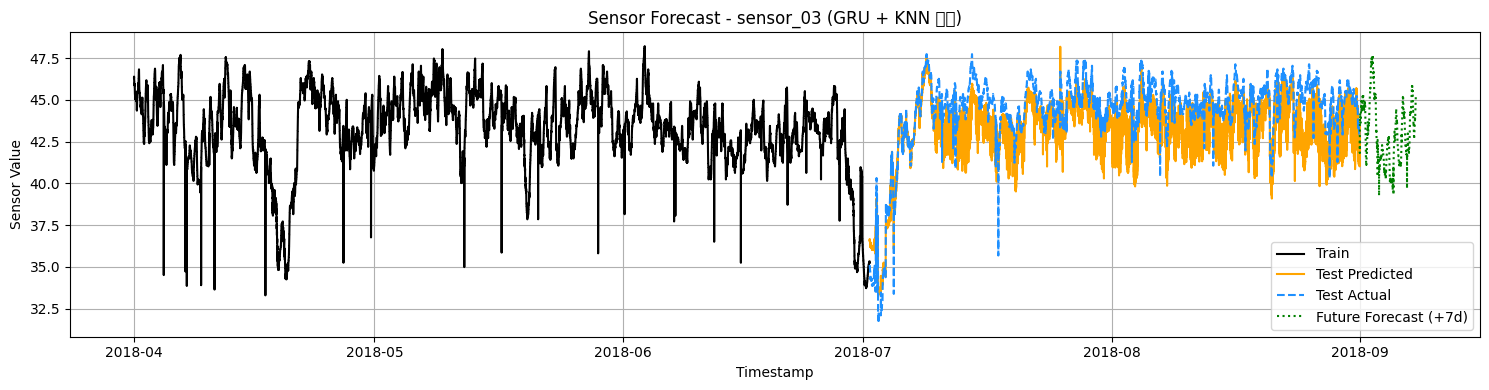

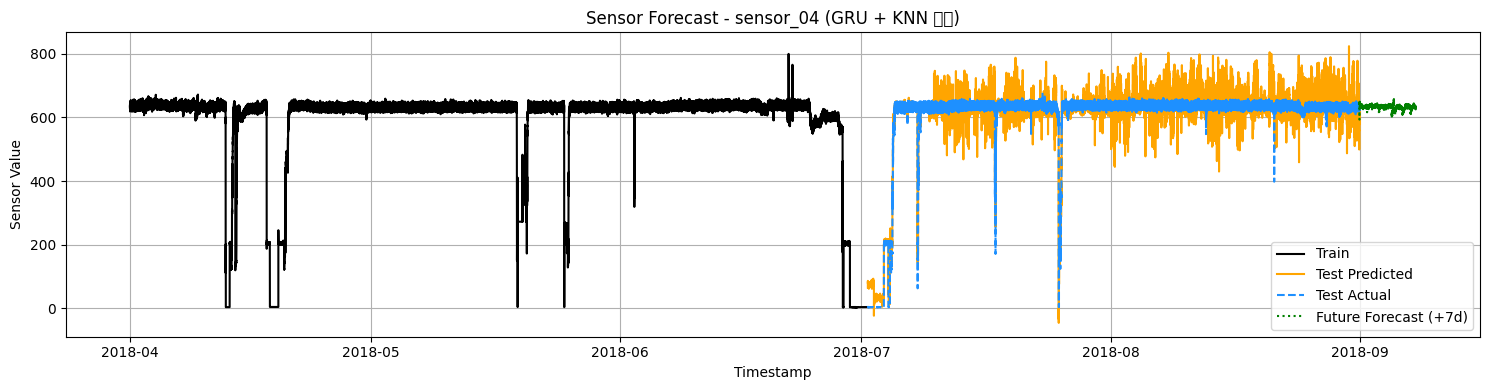

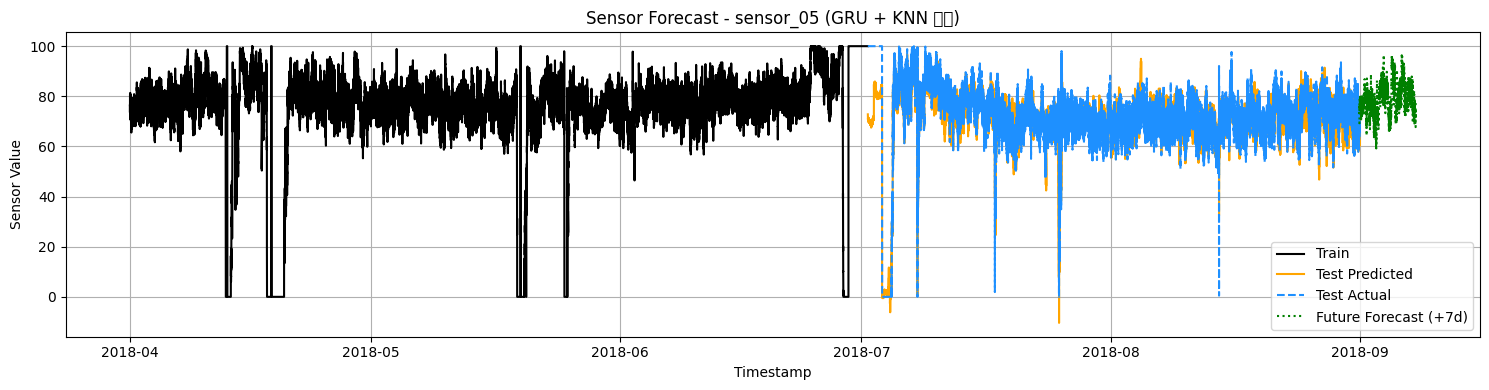

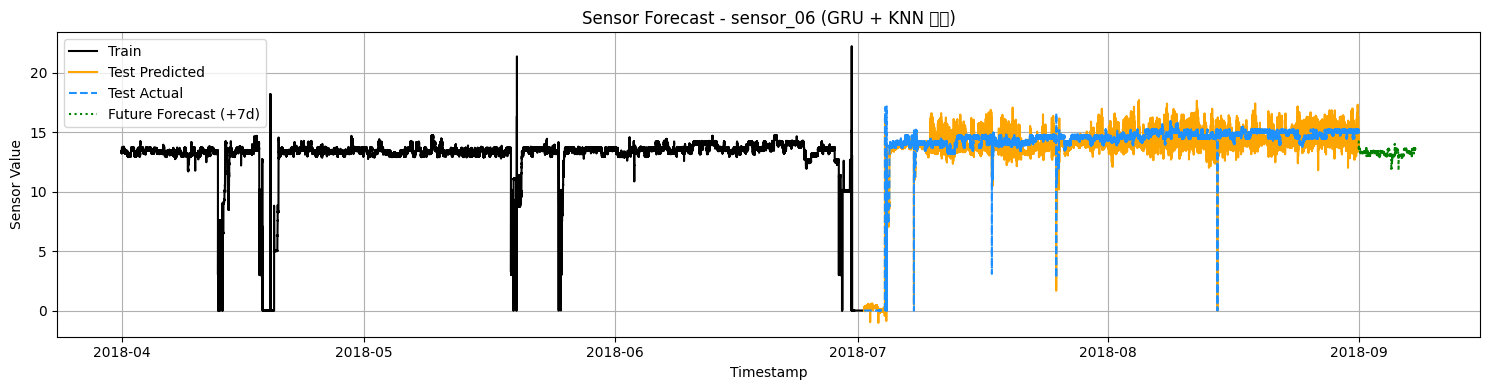

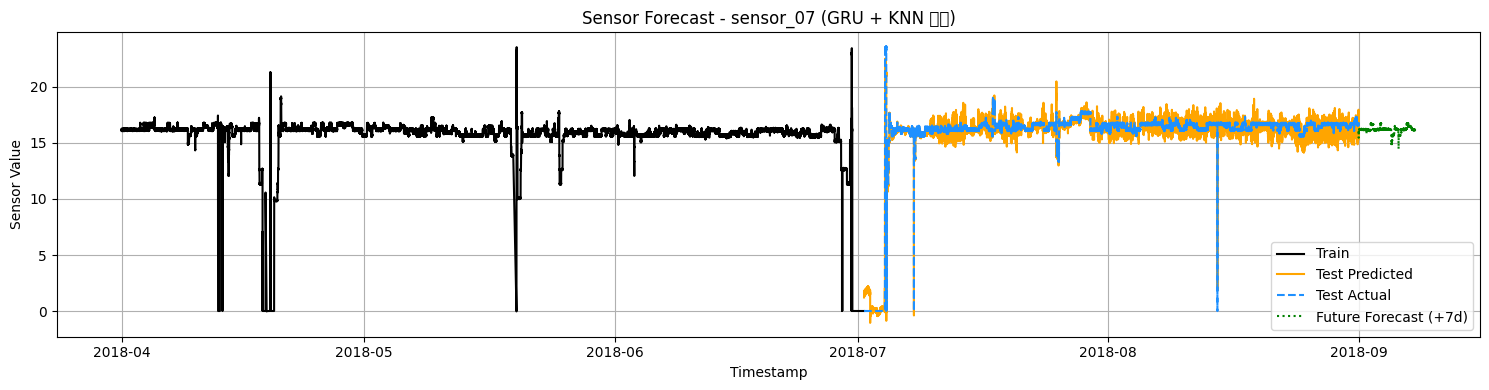

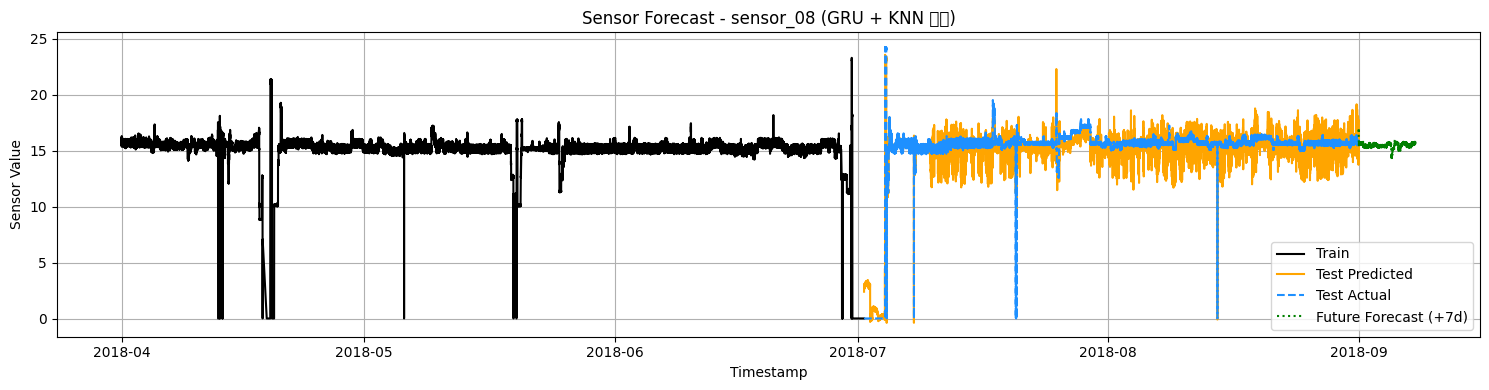

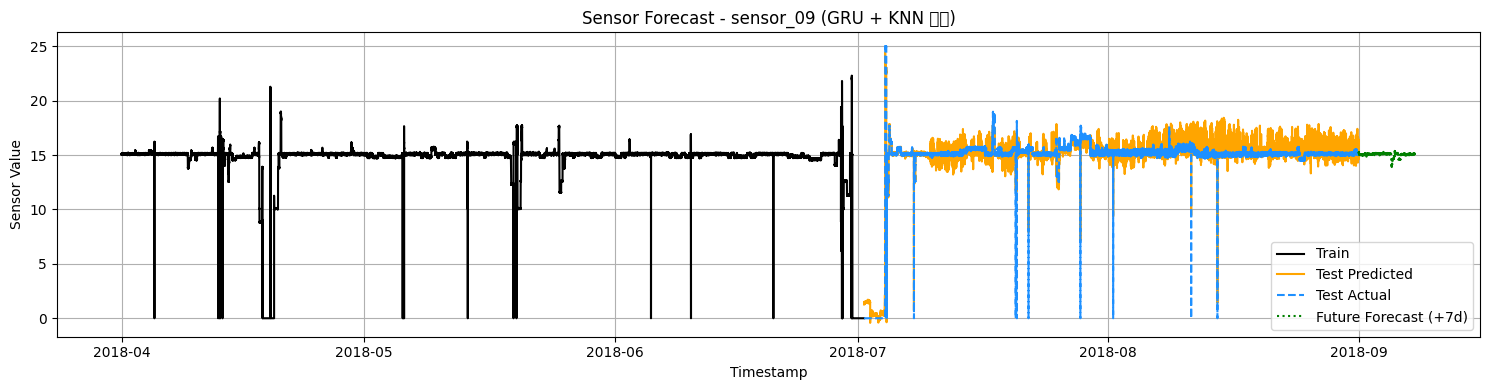

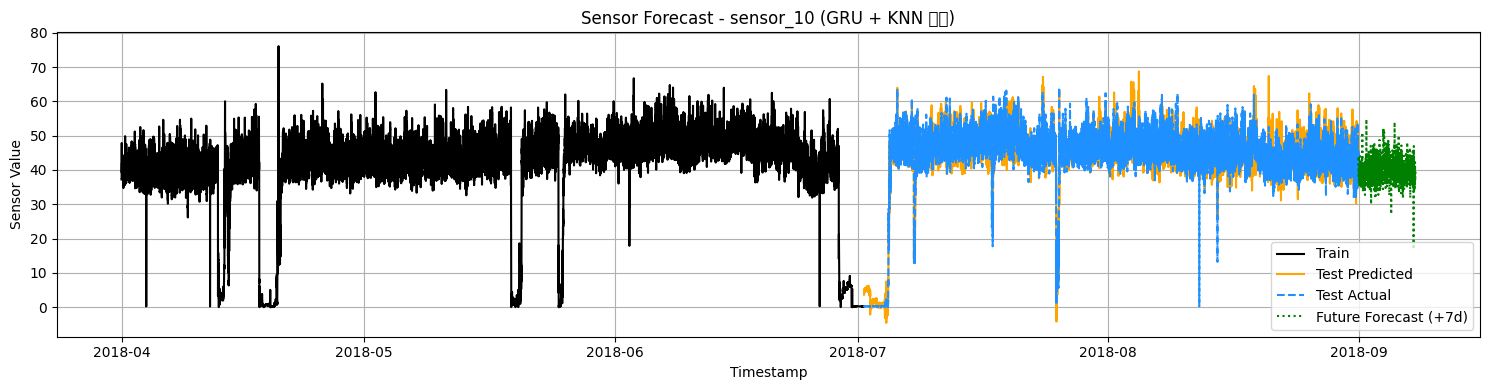

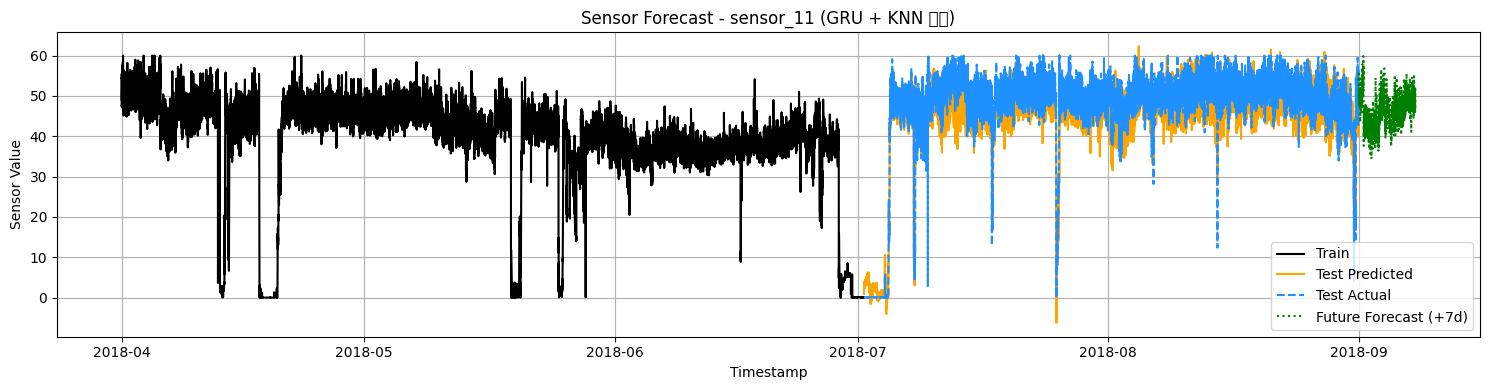

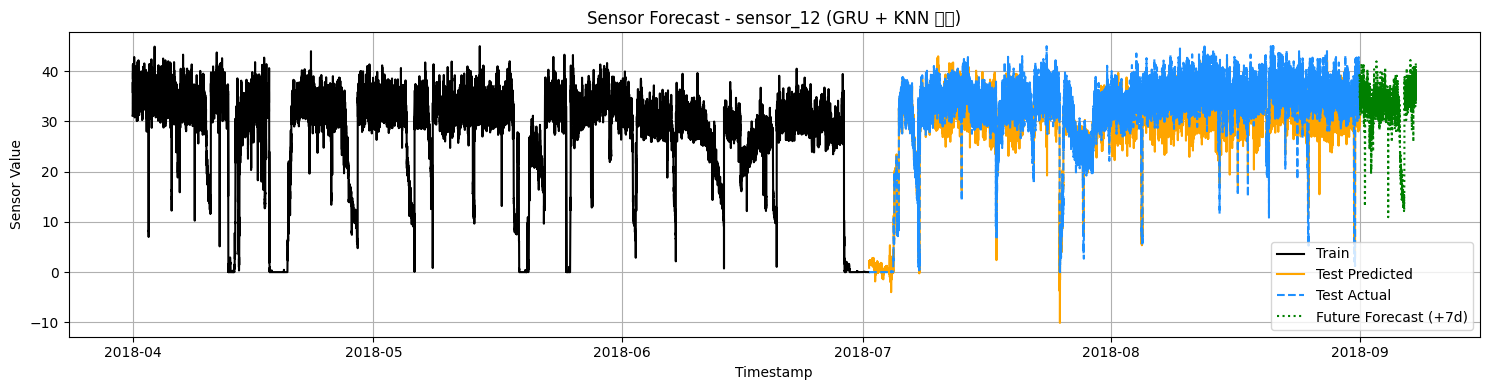

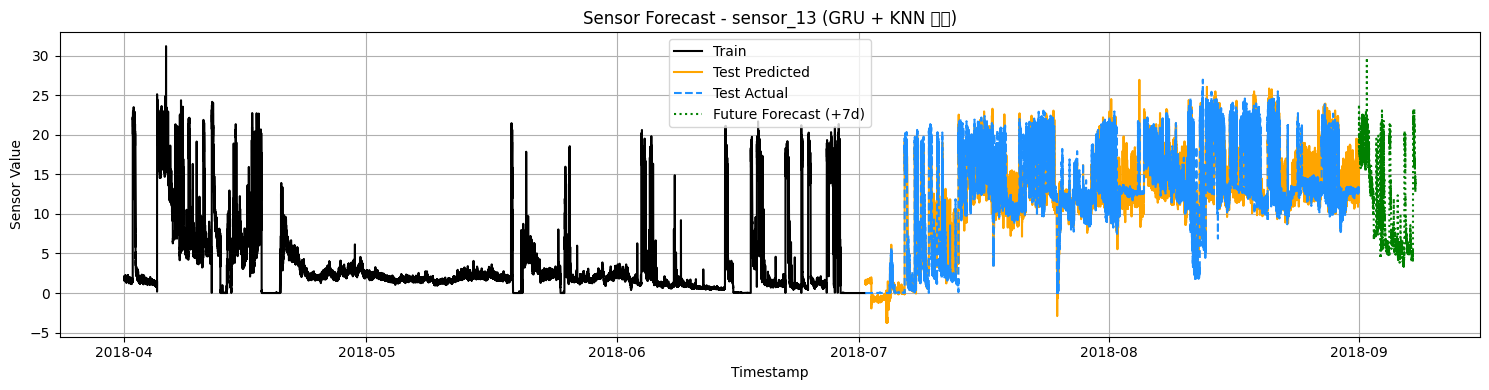

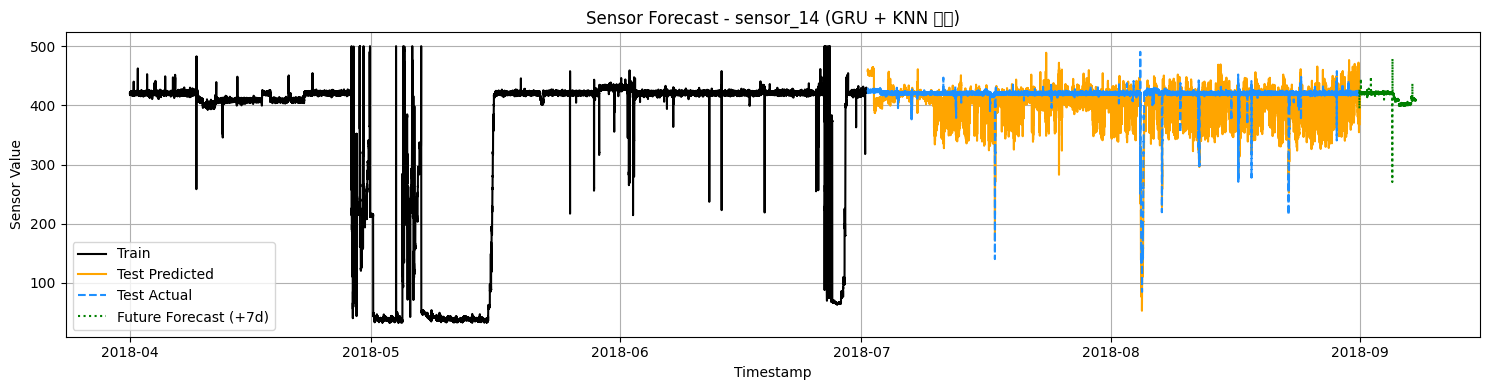

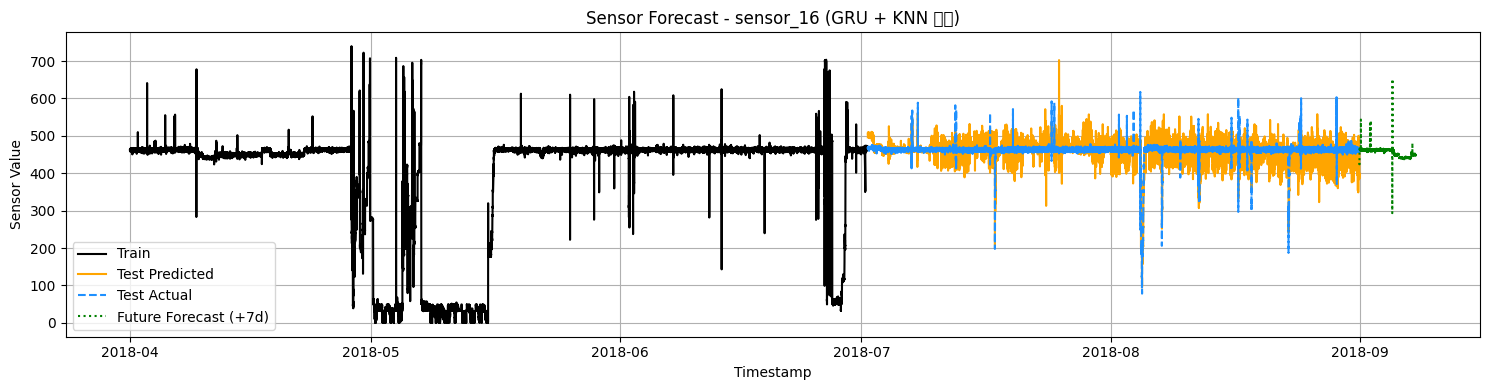

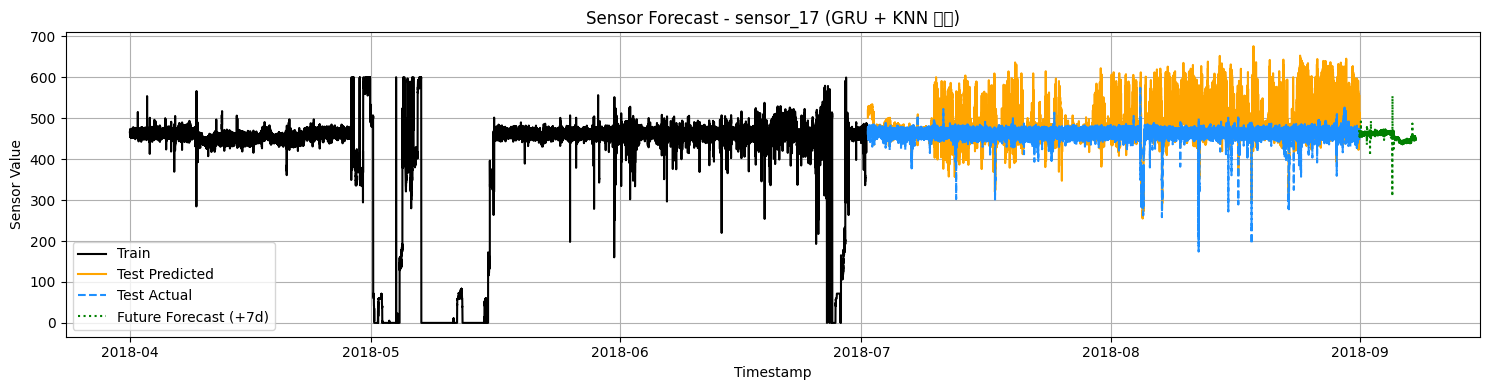

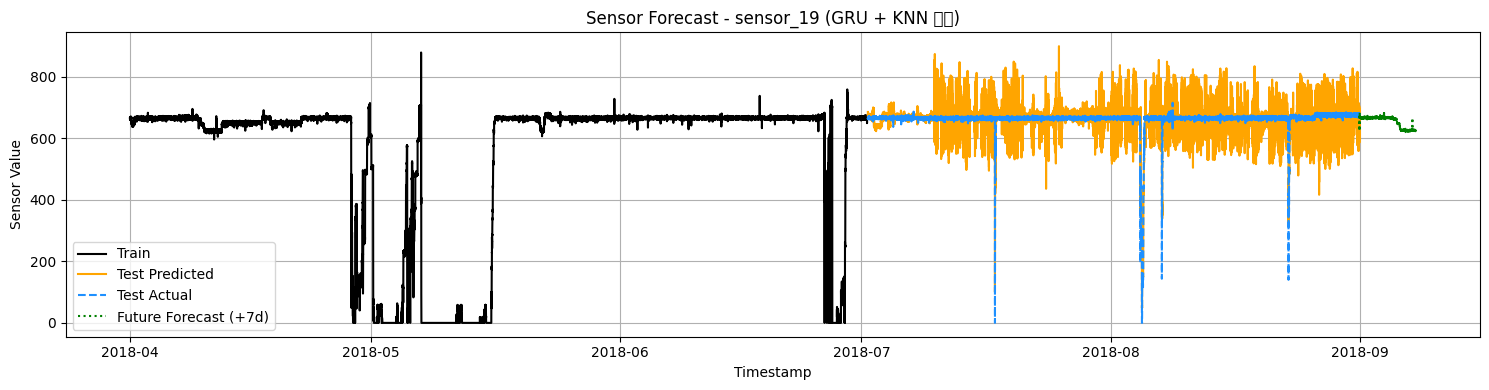

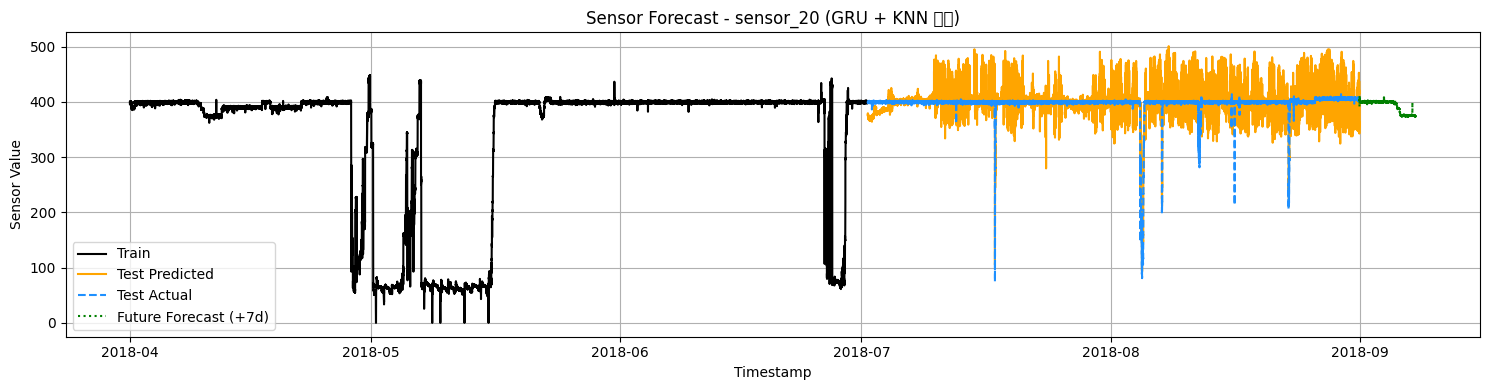

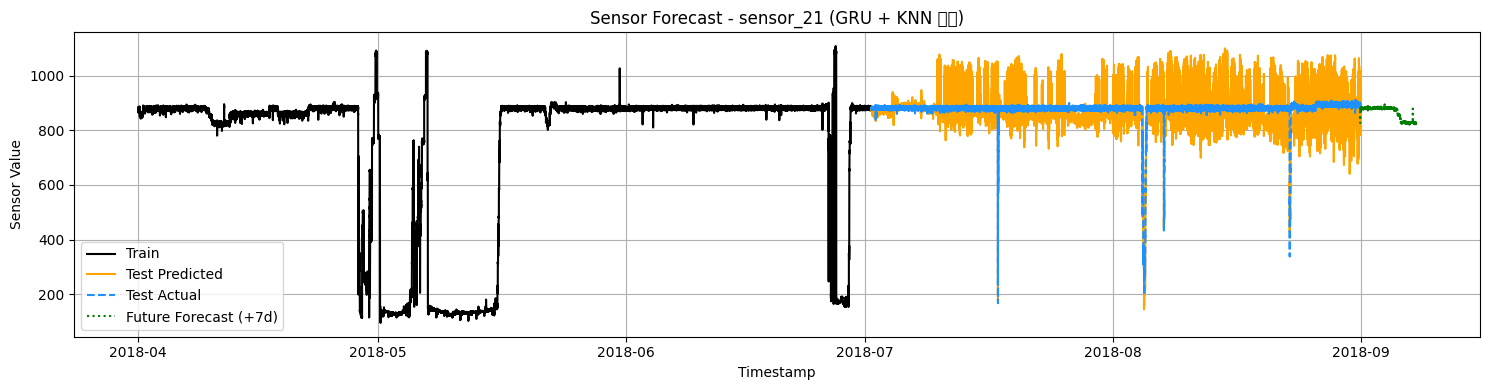

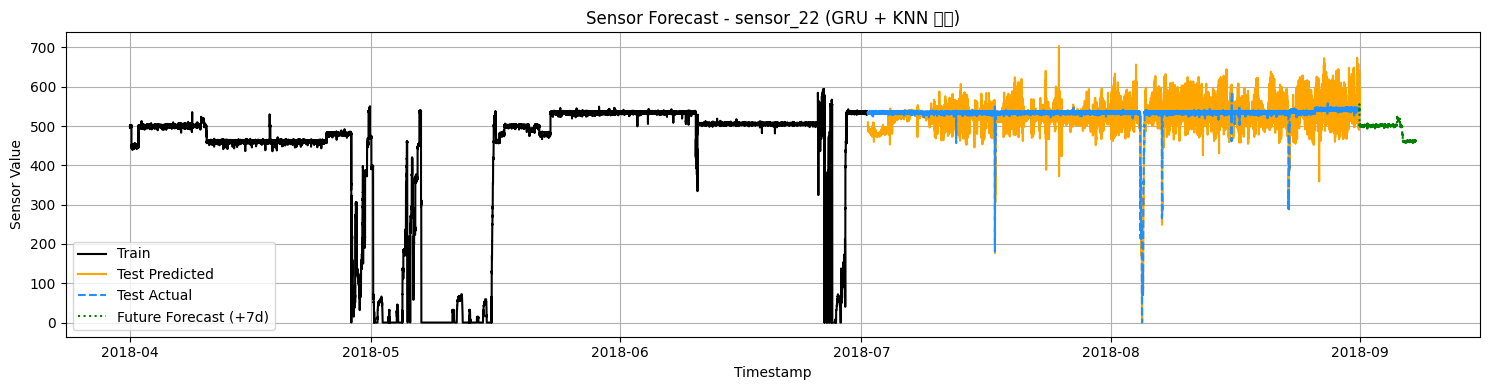

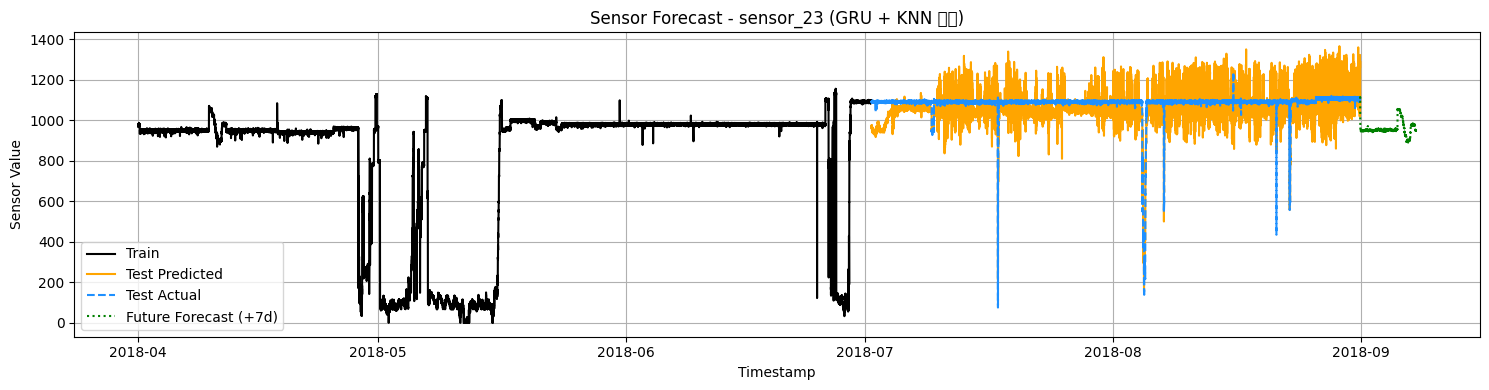

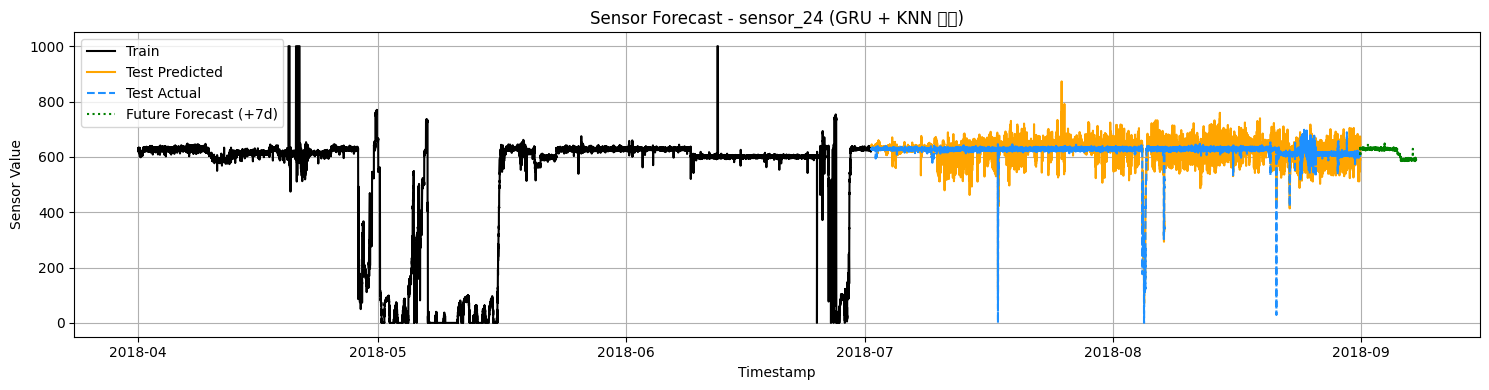

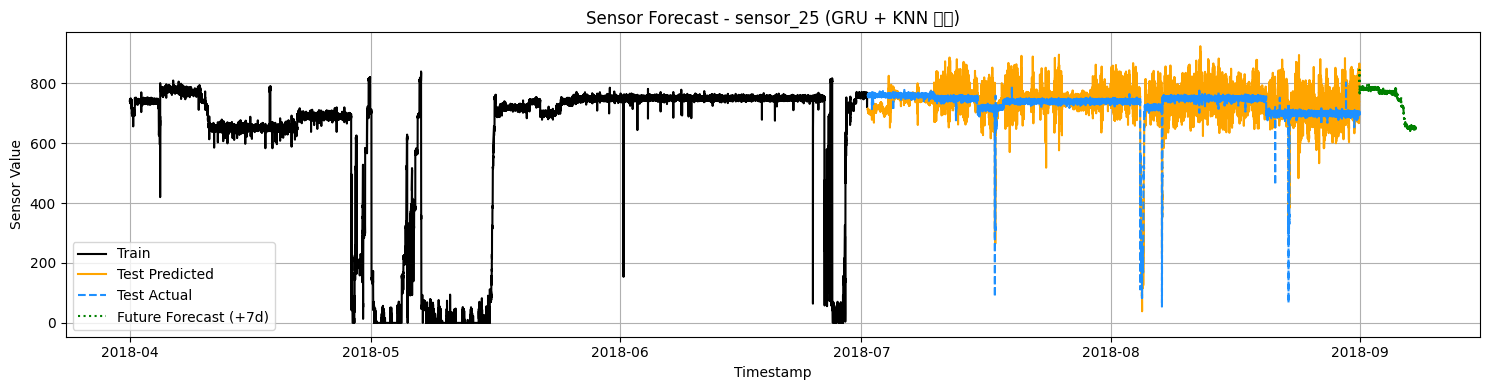

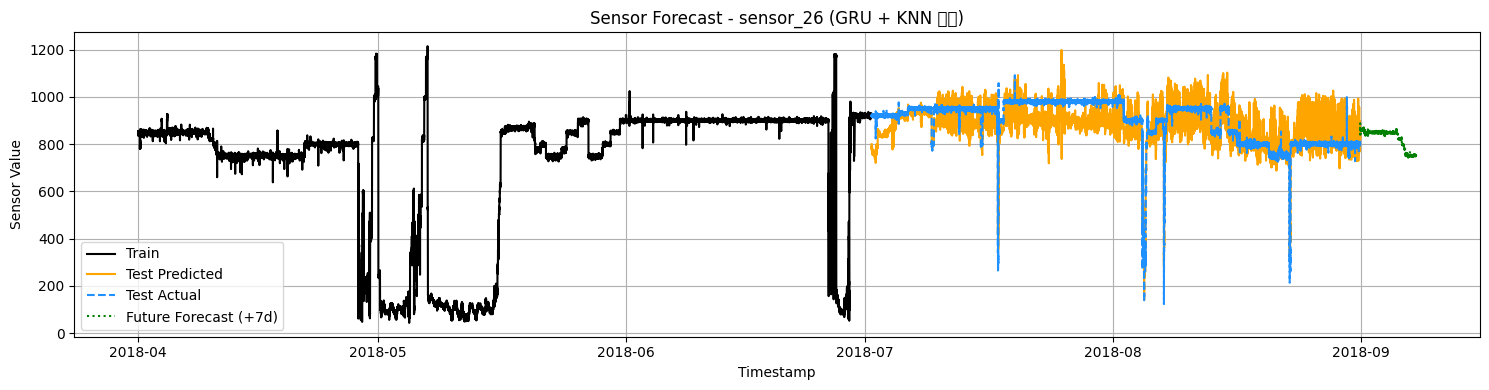

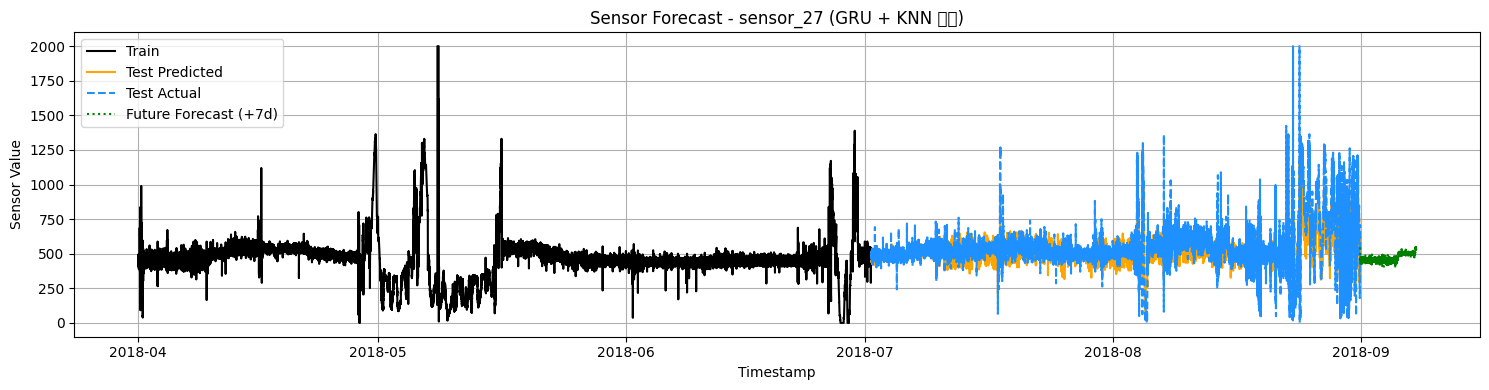

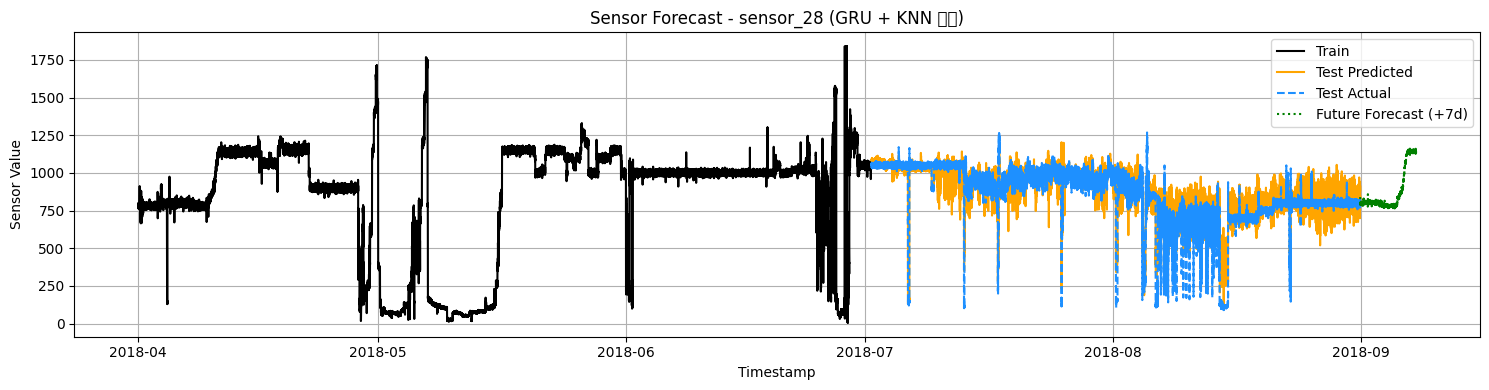

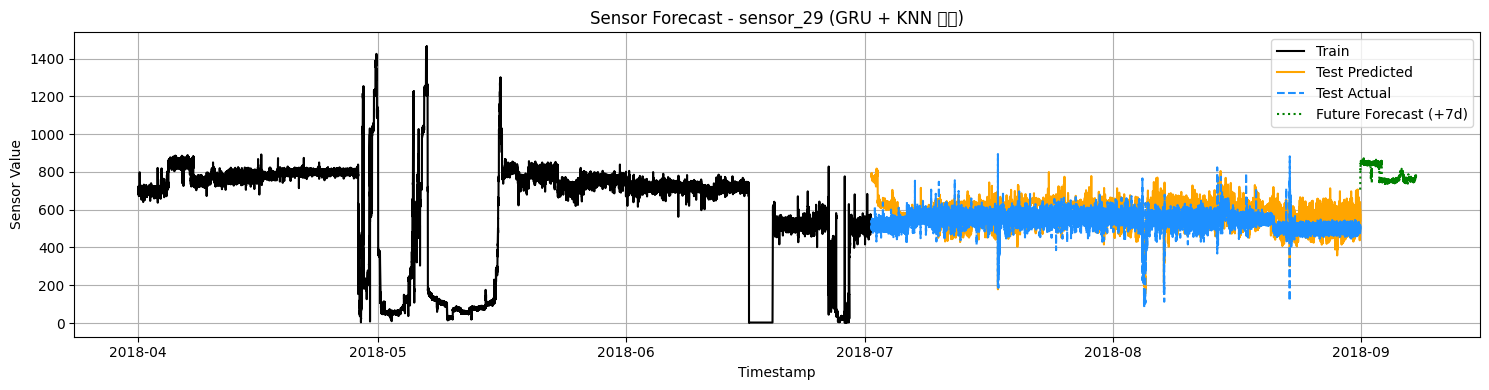

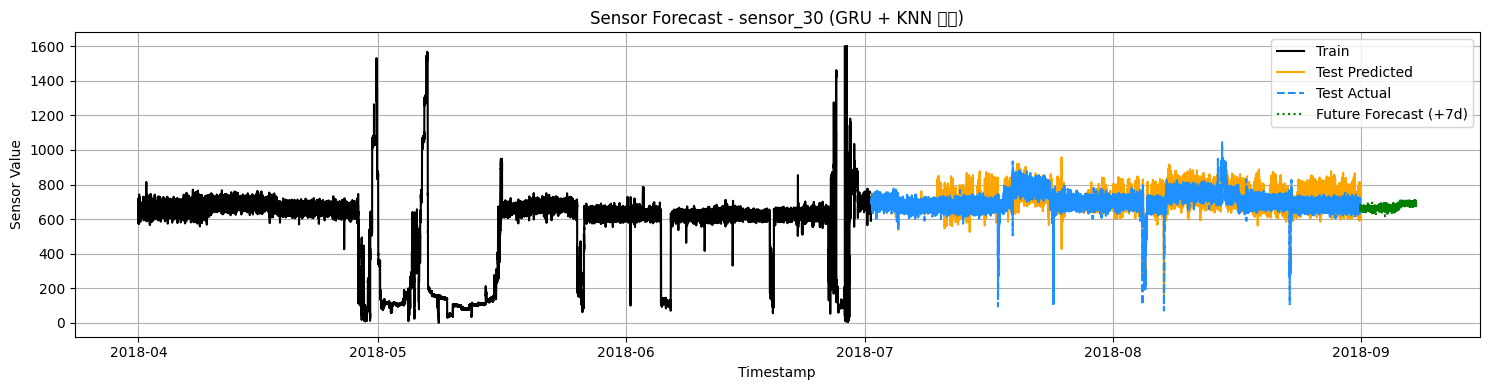

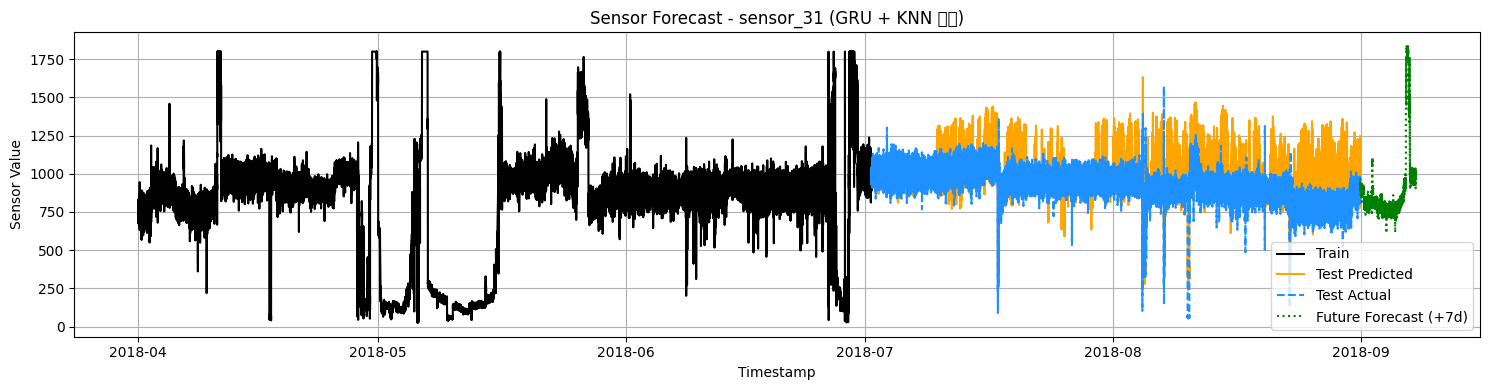

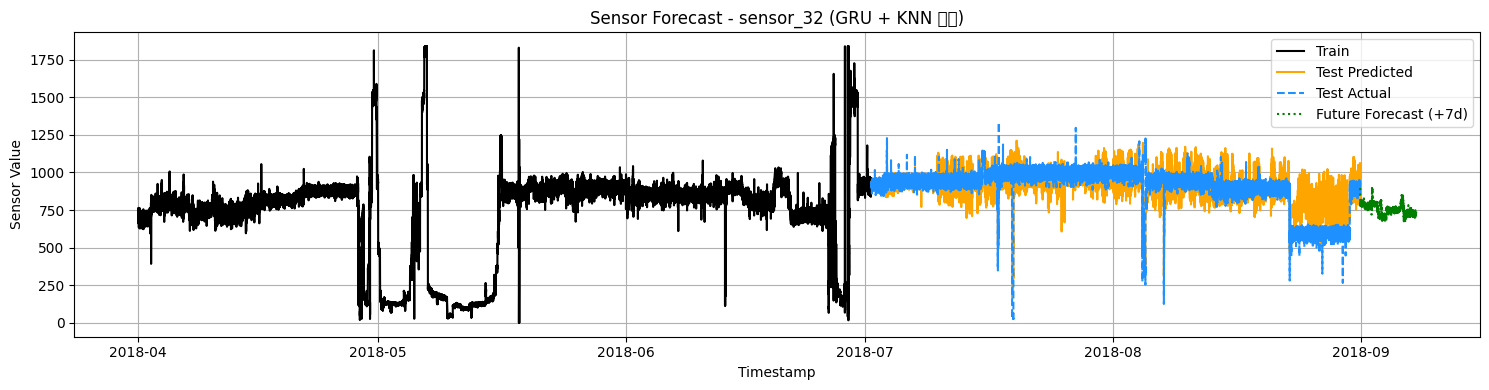

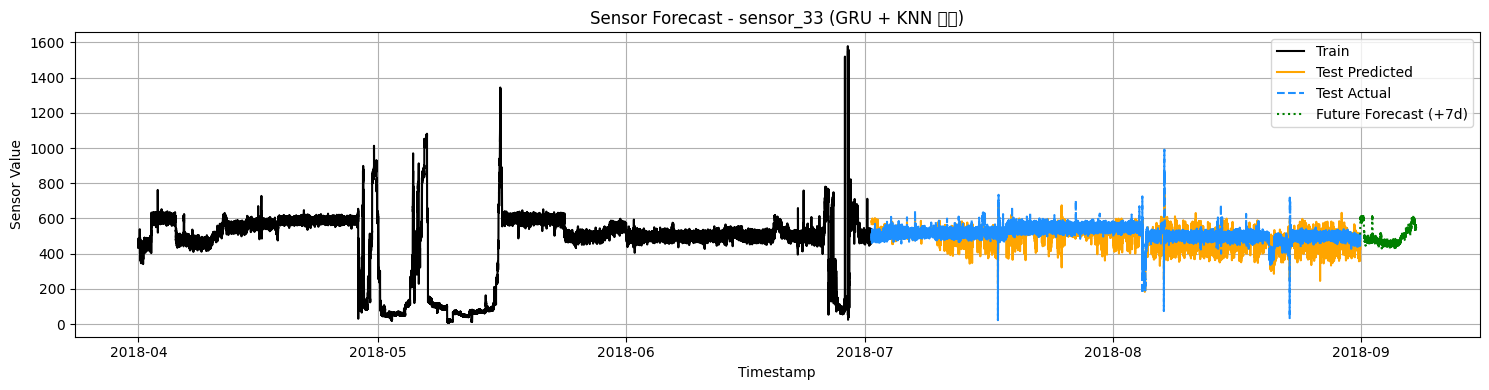

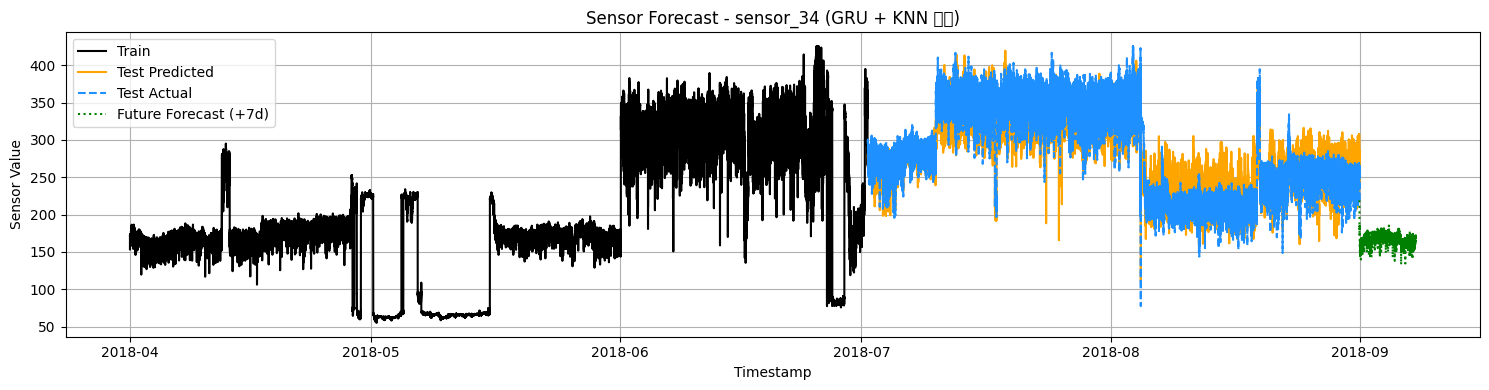

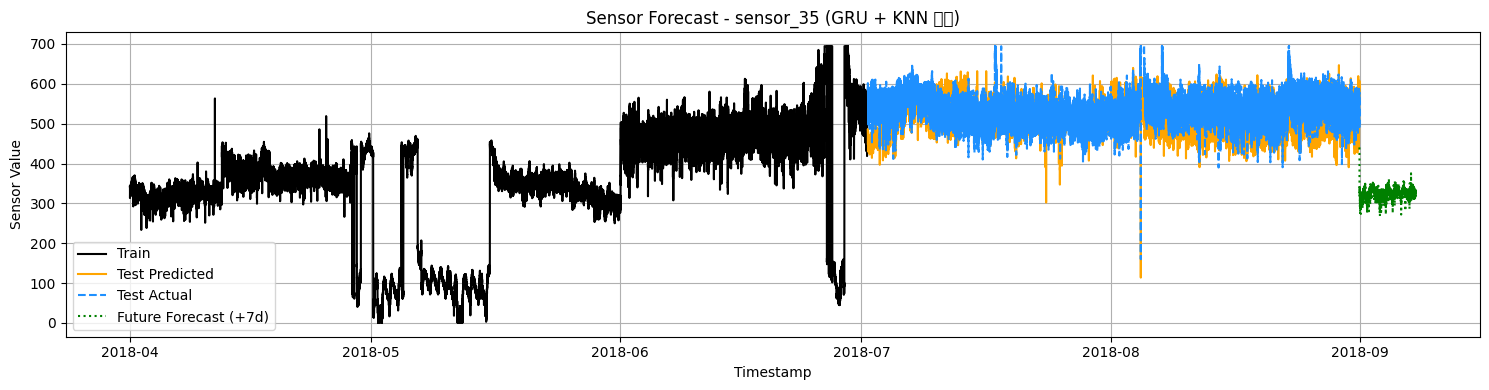

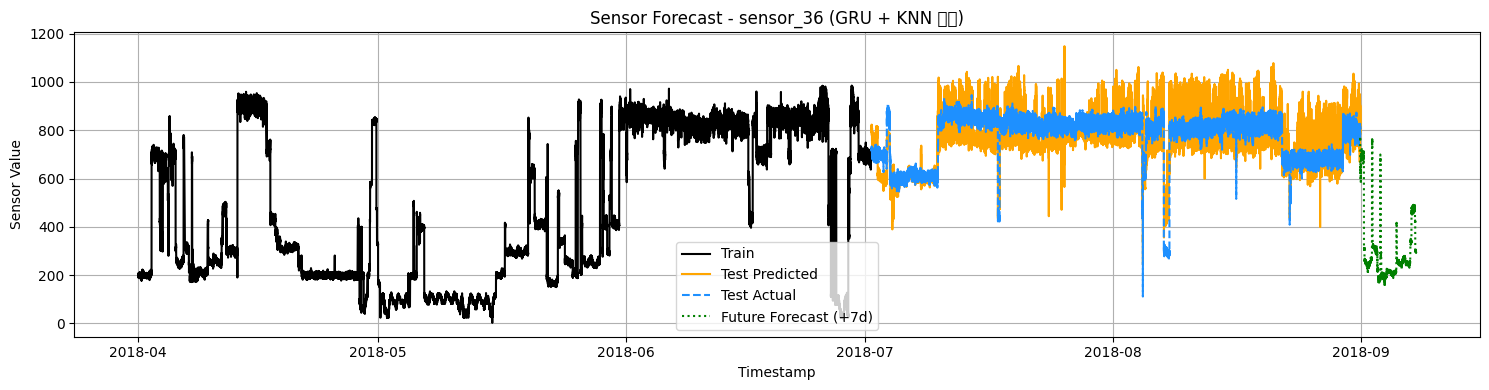

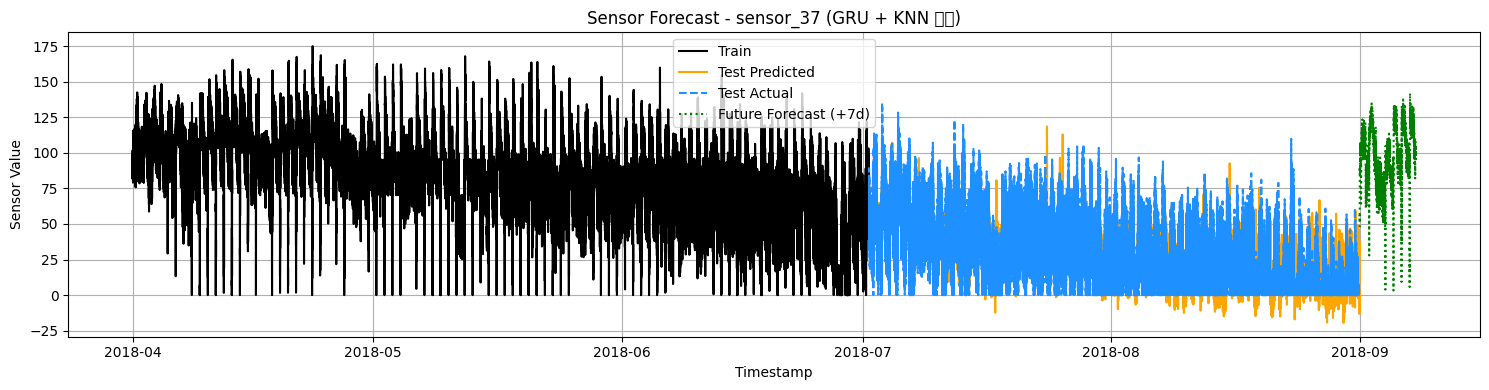

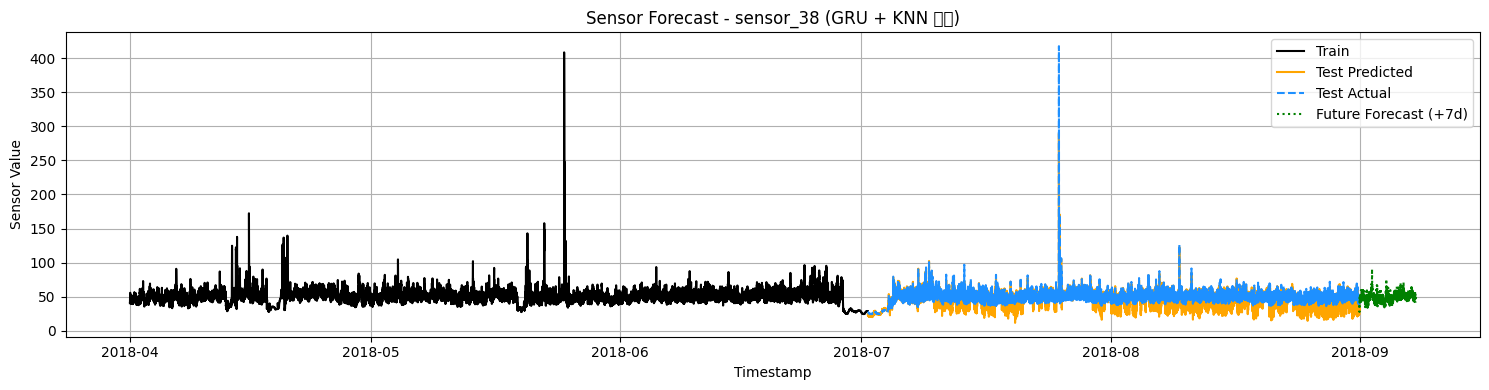

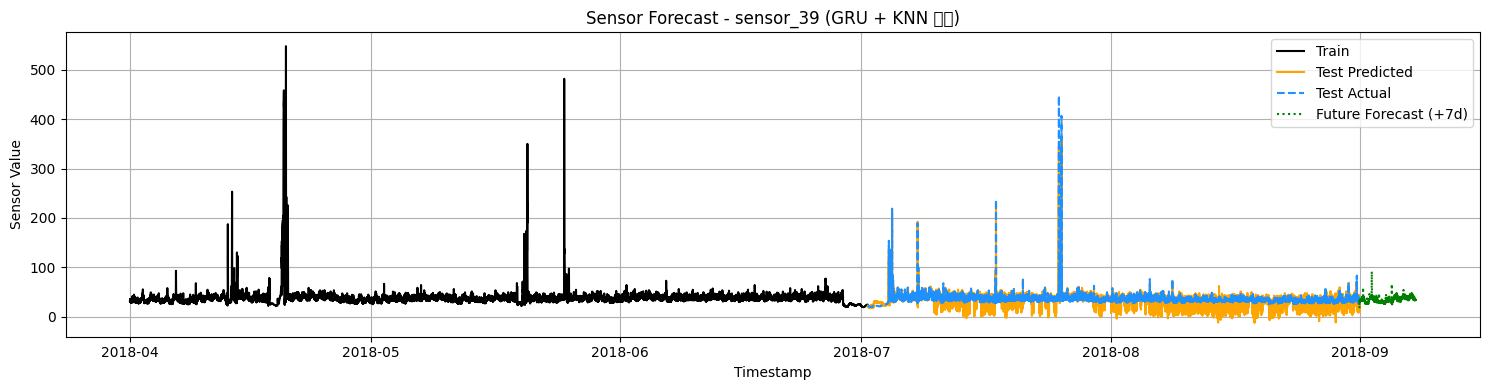

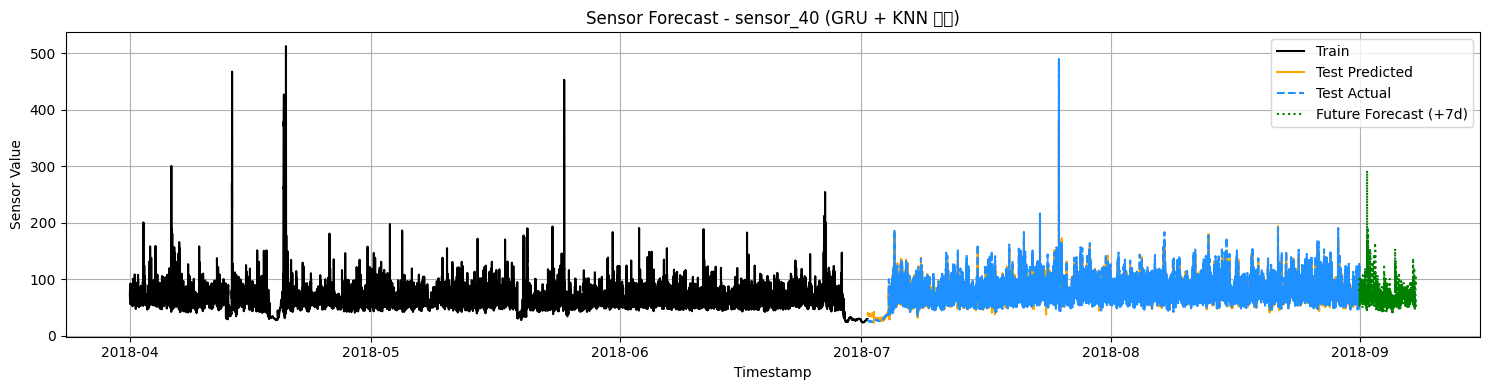

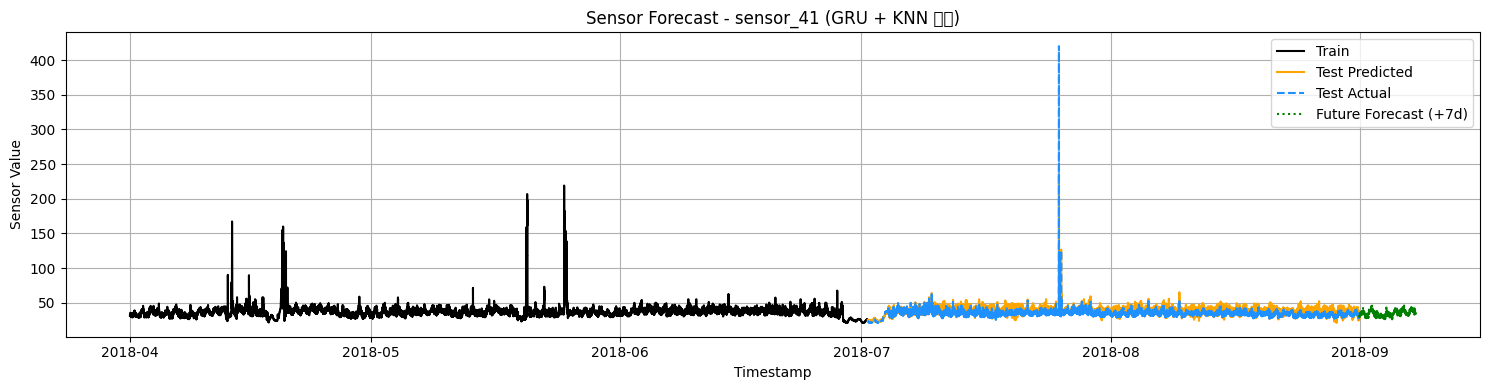

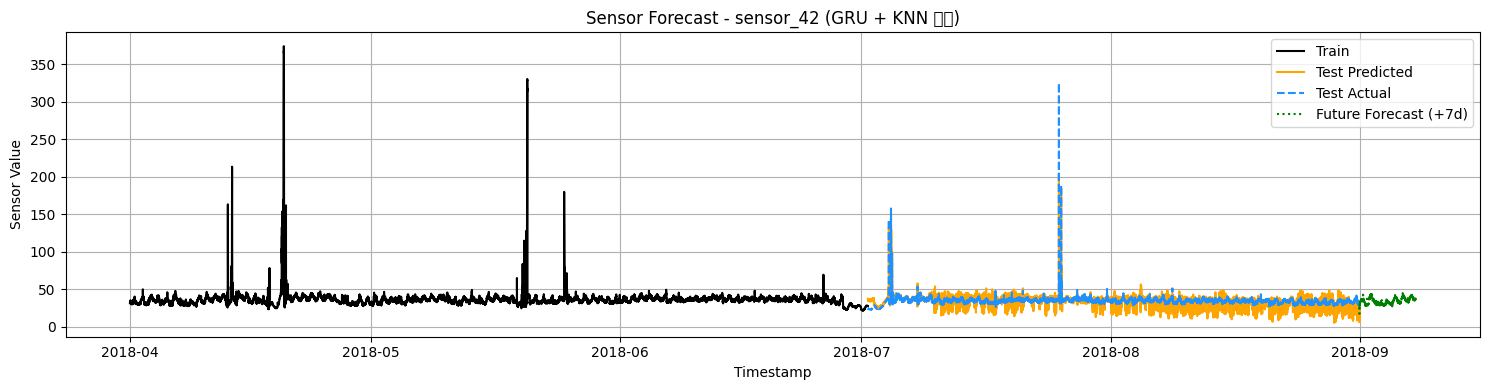

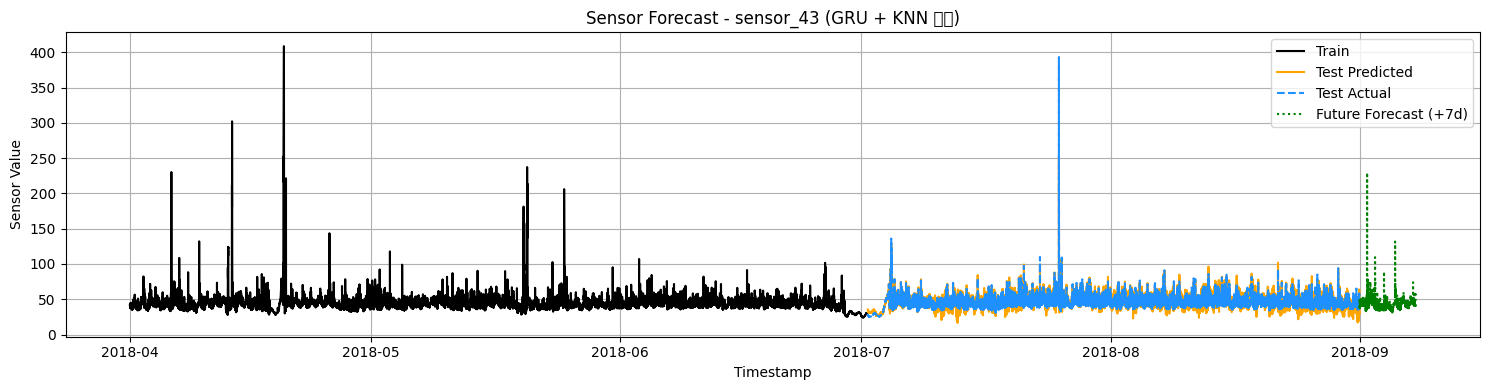

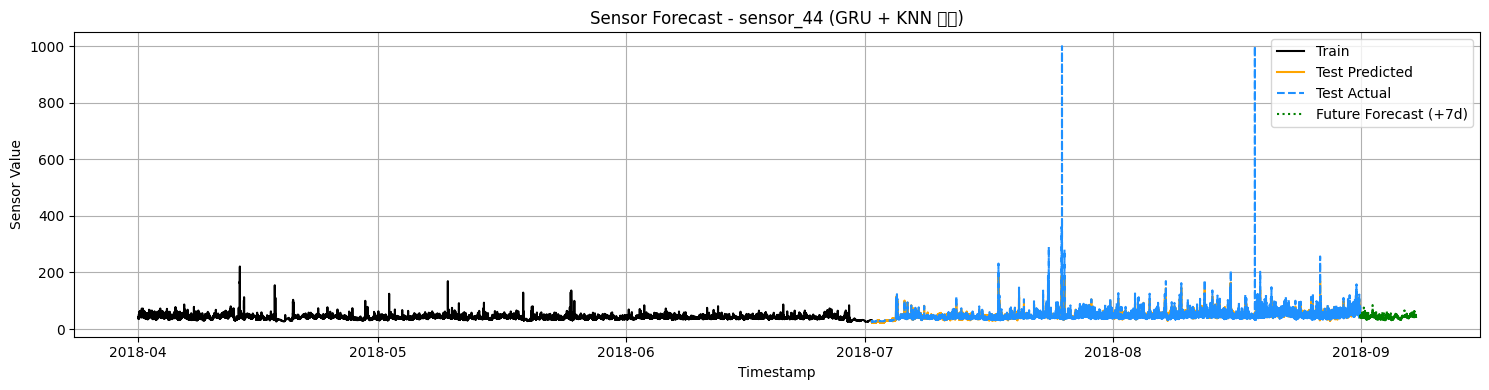

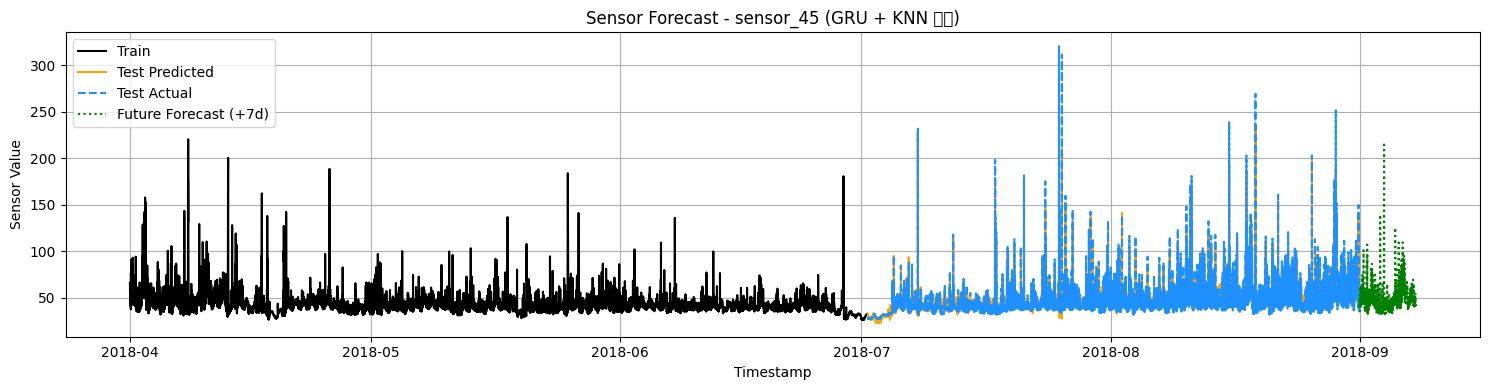

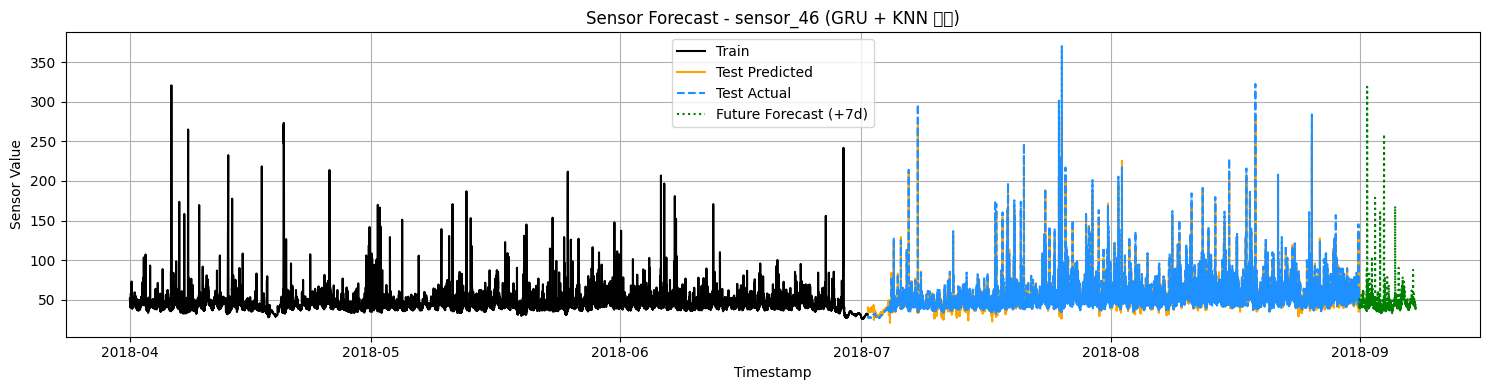

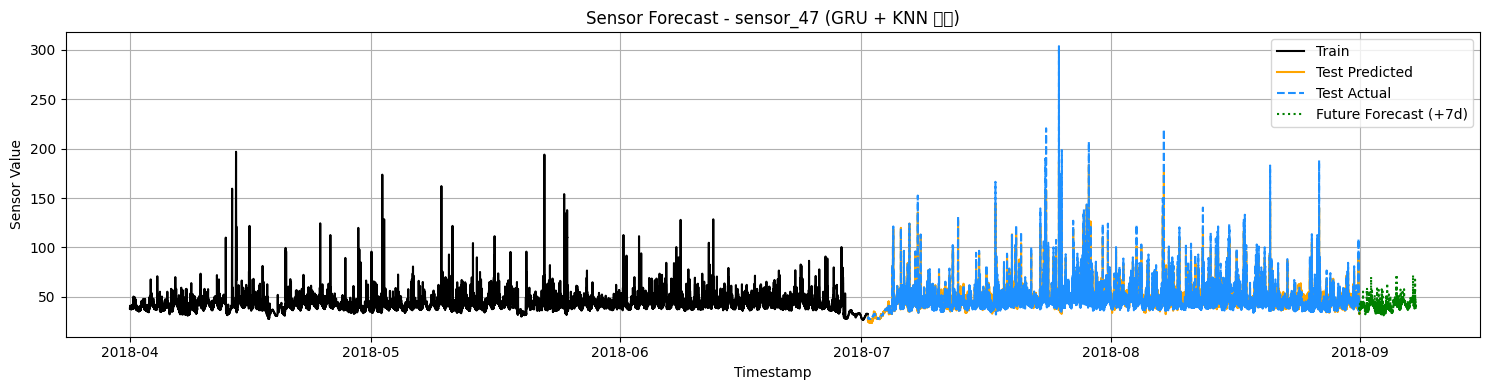

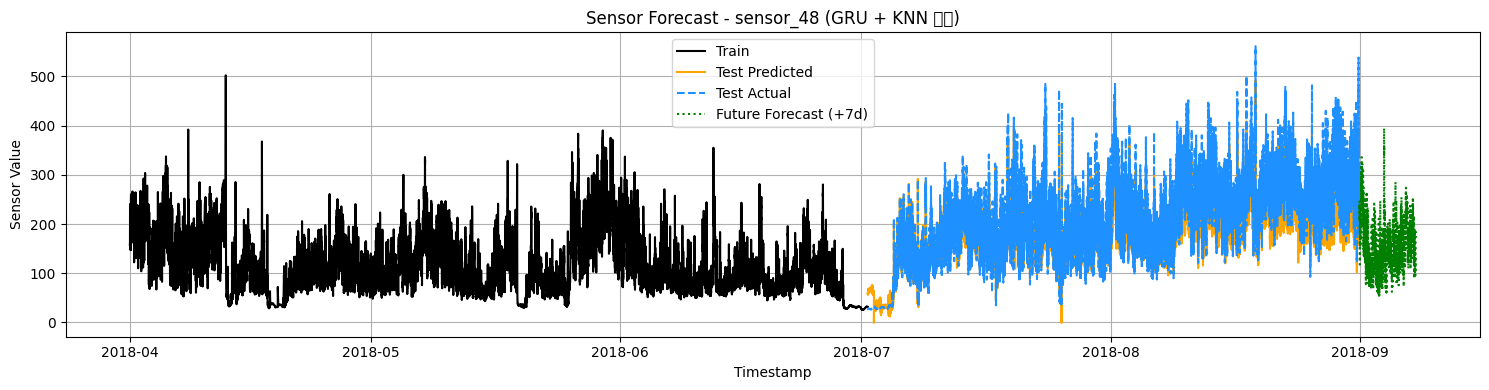

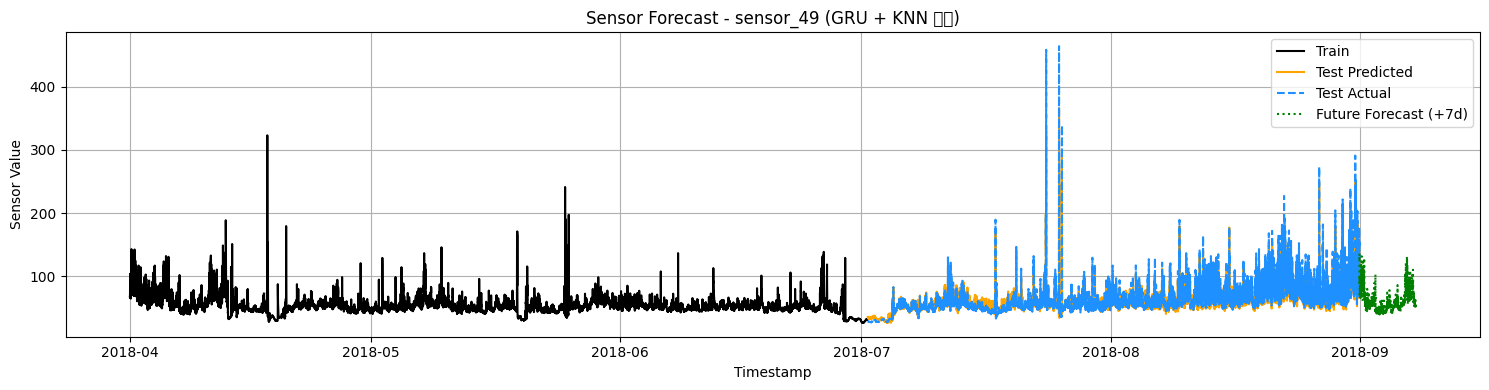

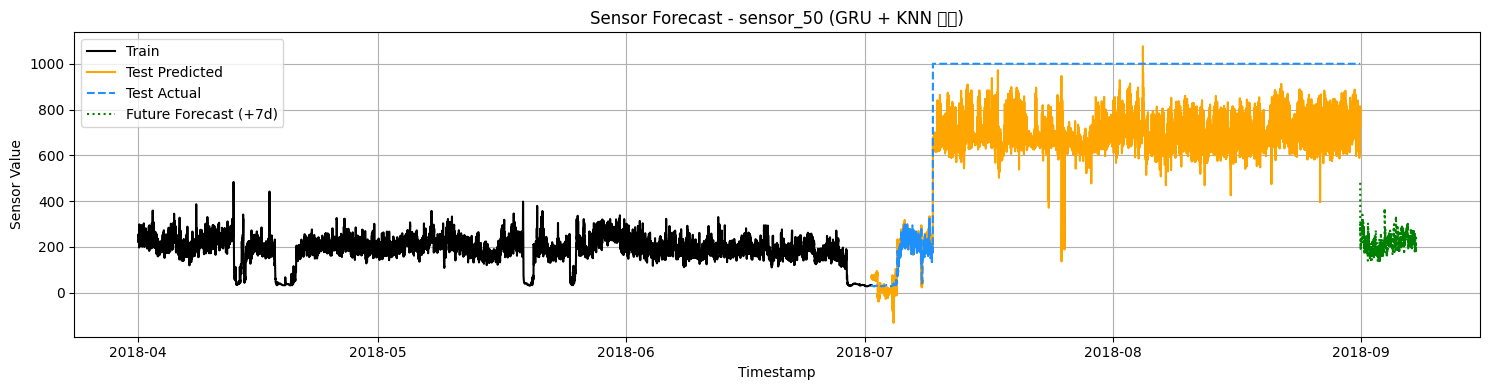

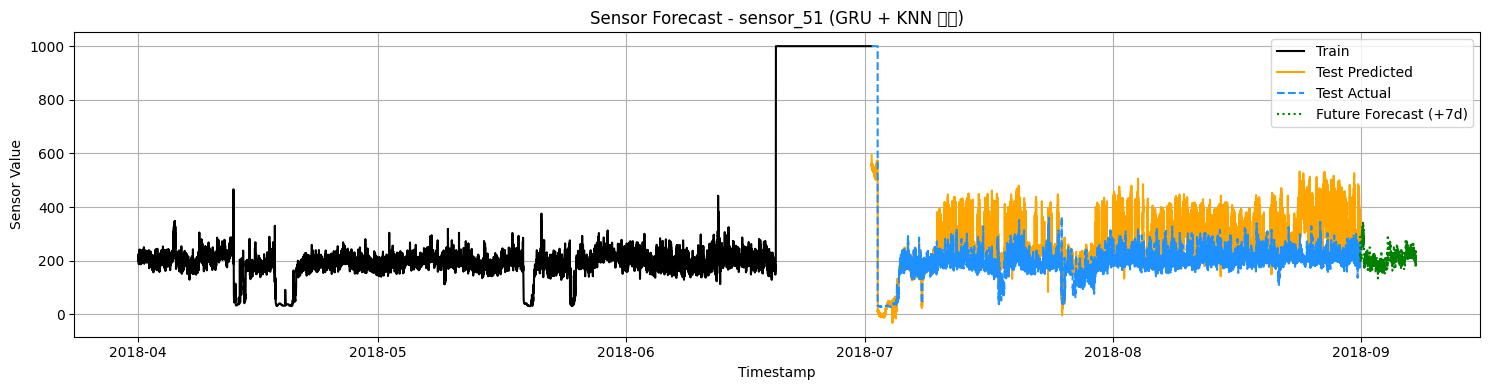

In [24]:
# 예측 트렌드 저장 (GRU+KNN 보정) - test구간 이후 시점 포함
window_bank, next_step_bank = [], []
train_arr = train_data[sensor_cols].values

for i in range(len(train_arr) - 60 - 1):
    window_bank.append(train_arr[i:i+60].flatten())
    next_step_bank.append(train_arr[i+60])

window_bank = np.array(window_bank)
next_step_bank = np.array(next_step_bank)

knn_model = NearestNeighbors(n_neighbors=3).fit(window_bank)

X_init = train_arr[-60:]
gru_first_pred = model.predict(X_init.reshape(1, 60, len(sensor_cols)))
gru_test_pred = model.predict(X_test)
gru_pred_full = np.vstack([gru_first_pred, gru_test_pred])

future_steps = 10080
future_preds = np.empty((future_steps, len(sensor_cols)))
last_input = X_test[-1:].copy()

for step in range(future_steps):
    pred = model.predict(last_input, verbose=0)[0]

    query = last_input.reshape(1, -1)
    indices = knn_model.kneighbors(query, return_distance=False)
    similar_nexts = next_step_bank[indices[0]]

    corrected = (pred + np.mean(similar_nexts, axis=0)) / 2
    future_preds[step] = corrected

    last_input = np.concatenate([last_input[:, 1:, :], corrected.reshape(1, 1, -1)], axis=1)

train_values_orig = scaler.inverse_transform(train_data[sensor_cols].values)
y_test_orig = scaler.inverse_transform(y_test)
y_pred_orig = scaler.inverse_transform(gru_pred_full)
future_pred_orig  = scaler.inverse_transform(future_preds)

time_gap = test_data.index[1] - test_data.index[0]
start_time = train_data.index[-1] + time_gap
pred_timestamps = [start_time + i * time_gap for i in range(len(y_pred_orig))]
future_timestamps = [pred_timestamps[-1] + (i+1)*time_gap for i in range(future_steps)]

for i, sensor in enumerate(sensor_cols):
    plt.figure(figsize=(15, 4))
    plt.plot(train_data.index, train_values_orig[:, i], label="Train", color="black")
    plt.plot(pred_timestamps, y_pred_orig[:, i], label="Test Predicted", color="orange")
    plt.plot(pred_timestamps[1:], y_test_orig[:, i], label="Test Actual", color="dodgerblue", linestyle='--')
    plt.plot(future_timestamps, future_pred_orig[:, i], label="Future Forecast (+7d)", color="green", linestyle=':')
    plt.title(f"Sensor Forecast - {sensor} (GRU + KNN 보정)")
    plt.xlabel("Timestamp")
    plt.ylabel("Sensor Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()